# Introduction

We were provided with 30k instances of labeled images and 30k instances of unlabeled images. The images are greyscale and varyingly noisy. The semantic data represented by these images is an upright pair of symbols: one digit (0-9) and one latin-alphabet character (a-z, A-Z); the labels of these images did not distinguish between upper- and lower-case characters.

In order to make the most of the data made available to us, we utilize the unlabeled data by applying the SESEMI technique of inventing an auxiliary, artificial supervised learning task with pseudo-labels derived by applying semantic-preserving transforms (right-angle rotations and horizontal and vertical flips), whereby the model is then able to derive the semantically useful information implicitly.

# Imports

In [ ]:
import random
from typing import Optional

# data parsing and data structures
import numpy as np
import pandas as pd
import pickle as pkl
import csv
import argparse
from urllib.request import urlopen

# everything sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay
)

# everything pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

from torchvision import datasets, transforms
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.io import read_image

# for plots
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Data

## Load

In [ ]:
# Google drive storage
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/COMP551_project3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/COMP551_project3


In [ ]:
# Local storage from mounted runtime
with open("labels_l.pkl", 'rb') as f:
  labels = pkl.load(f)
with open("images_l.pkl", 'rb') as f:
  images_l = pkl.load(f)
with open("images_ul.pkl", 'rb') as f:
  images_ul = pkl.load(f)
with open("images_test.pkl", 'rb') as f:
  images_test = pkl.load(f)

In [ ]:
# Essen's dropbox (use as last resort)
with urlopen("https://www.dropbox.com/s/kjux09vy8udt6dd/labels_l.pkl?dl=1") as f:
  labels = pkl.load(f)
with urlopen("https://www.dropbox.com/s/xe81d4n90ra8ck5/images_l.pkl?dl=1") as f:
  images_l = pkl.load(f)
with urlopen("https://www.dropbox.com/s/8rszorfqrl0v9eh/images_ul.pkl?dl=1") as f:
  images_ul = pkl.load(f)
with urlopen("https://www.dropbox.com/s/m0lqximhtj6sa1m/images_test.pkl?dl=1") as f:
  images_test = pkl.load(f)

## Decode

In [ ]:
num_categories = [0,1,2,3,4,5,6,7,8,9]
char_categories = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
ohe = OneHotEncoder(categories=[num_categories,char_categories])
ohe.fit([[0,"a"]])
decoded_labels = ohe.inverse_transform(labels)
le = LabelEncoder()
le.fit(char_categories)
decoded_labels[:,1] = le.transform(decoded_labels[:,1])

## Explore

In [ ]:
print(type(labels))
print(labels.shape)

<class 'numpy.ndarray'>
(30000, 36)


In [ ]:
print(type(images_l))
print(images_l.shape)

<class 'numpy.ndarray'>
(30000, 56, 56)


In [ ]:
print(type(images_ul))
print(images_ul.shape)

<class 'numpy.ndarray'>
(30000, 56, 56)


In [ ]:
print(type(images_test))
print(images_test.shape)

<class 'numpy.ndarray'>
(15000, 56, 56)


In [ ]:
# Distribution of labels
digits = []
characters = []
categories = []
for l in labels:
  digits.append(ohe.inverse_transform([l])[0][0])
  characters.append(ohe.inverse_transform([l])[0][1])
  categories.append(str(ohe.inverse_transform([l])[0][0]) + ohe.inverse_transform([l])[0][1])

print(categories)  

['9e', '5q', '8i', '5b', '4u', '5m', '6g', '8u', '4q', '0c', '8k', '5l', '3c', '3z', '6b', '2m', '4n', '8r', '0n', '2t', '5l', '4v', '9o', '1b', '5l', '6y', '0m', '7v', '5d', '5a', '2s', '8p', '2s', '4v', '5n', '3t', '5q', '9v', '0r', '0b', '1o', '3m', '1n', '3s', '6h', '0o', '6l', '9v', '0s', '3e', '3v', '5m', '8a', '2l', '8c', '8v', '0f', '2p', '6n', '1l', '2c', '9x', '0c', '3m', '8f', '9z', '1s', '7z', '1y', '9q', '1u', '6q', '5r', '3l', '3s', '4c', '4t', '7f', '0r', '0w', '2e', '0u', '0n', '8s', '9i', '7a', '0v', '6y', '1o', '2e', '5p', '1h', '0j', '8e', '4u', '1a', '3t', '4h', '1y', '6e', '0x', '8e', '3n', '5g', '0v', '8y', '8y', '7e', '2a', '9o', '8s', '4k', '8s', '5q', '1o', '2c', '3d', '5p', '5v', '4g', '0u', '6n', '9w', '5z', '6z', '8i', '7f', '8b', '5e', '1j', '3b', '2p', '2m', '9d', '0z', '0d', '3p', '0k', '4b', '5w', '2w', '5b', '0z', '2g', '0u', '8h', '2c', '0f', '3o', '0s', '0k', '4b', '0v', '5g', '6j', '1s', '5h', '4k', '5g', '5j', '8s', '9u', '5u', '6y', '1h', '0g', '1z

In [ ]:
# had to add invisible character before string for descending order to work
fig = go.Figure(data=[go.Histogram(x=["ㅤ" + str(x) for x in digits], cumulative_enabled=False)],
                layout=go.Layout(title = "Histogram of digits",
                                 title_x=0.5,
                                 xaxis_title = "digit",
                                 yaxis_title = "frequency",
                                 height=500, width=500) ) 
fig.update_xaxes(categoryorder='total descending')
fig.show(renderer="colab")

In [ ]:
# had to add invisible character before string for descending order to work
fig = go.Figure(data=[go.Histogram(x=characters, cumulative_enabled=False)],
                layout=go.Layout(title = "Histogram of characters",
                                 title_x=0.5,
                                 xaxis_title = "character",
                                 yaxis_title = "frequency",
                                 height=500, width=600) )
fig.update_xaxes(categoryorder='total descending')
fig.show(renderer="colab")

In [ ]:
# had to add invisible character before string for descending order to work
fig = go.Figure(data=[go.Histogram(x=categories, cumulative_enabled=False)],
                layout=go.Layout(title = "Histogram of label combinations",
                                 title_x=0.5,
                                 xaxis_title = "label",
                                 yaxis_title = "frequency",
                                 height=500, width=1200) )
fig.update_xaxes(categoryorder='total descending')
fig.show(renderer="colab")

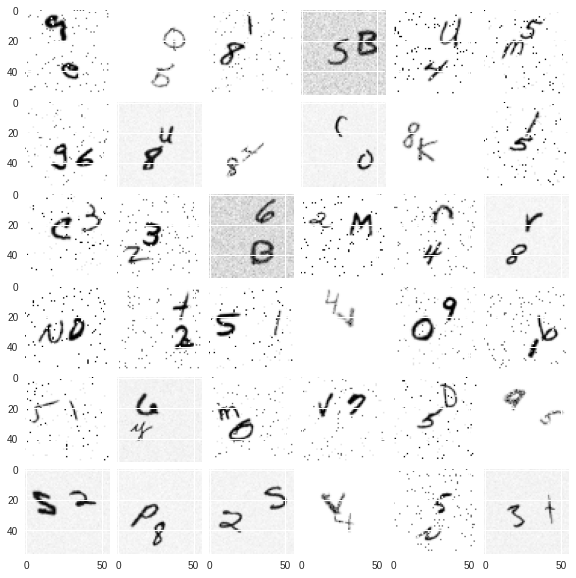

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(6, 6), 
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, images_l):
    ax.imshow(im)

In [ ]:
aug_dataloader = DataLoader(augmented_data, batch_size=6, shuffle=True)
img_aug = []
for i in range(6):
  d = iter(aug_dataloader).next()
  images_a = d["img"]
  images_a.tolist()
  img_aug.append(images_a)
i_aug = []
for i in range(6):
  for j in range(6):
    img = img_aug[i][j]*0.5 + 0.5     # unnormalize
    npimg = np.transpose(img.numpy(),(1,2,0))
    npimg = npimg[:,:,0]
    i_aug.append(npimg)

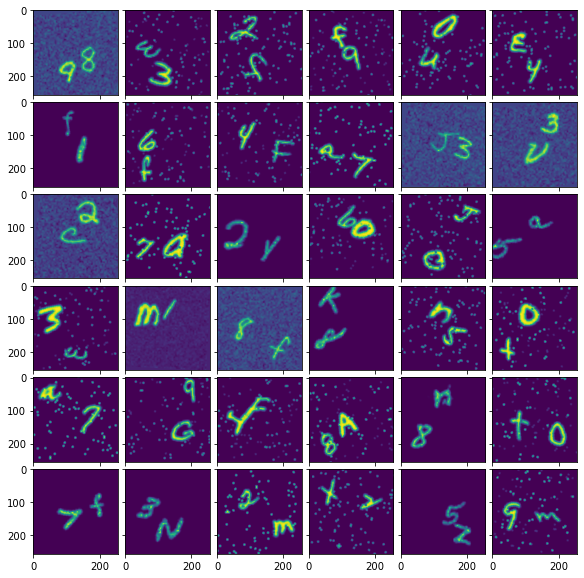

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig2 = plt.figure(figsize=(10., 10.))
grid2 = ImageGrid(fig2, 111, 
                 nrows_ncols=(6, 6), 
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid2, i_aug):
    ax.imshow(im)

In [ ]:
un_dataloader = DataLoader(unlabeled_data, batch_size=6, shuffle=True)
img_un  = []
for i in range(6):
  d = iter(un_dataloader).next()
  images_a = d["img"]
  images_a.tolist()
  img_un.append(images_a)

print(len(img_un[1]))
i_un = []
for i in range(6):
  for j in range(6):
    img = img_un[i][j]*0.5 + 0.5     # unnormalize
    npimg = np.transpose(img.numpy(),(1,2,0))
    npimg = npimg[:,:,0]
    i_un.append(npimg)


6


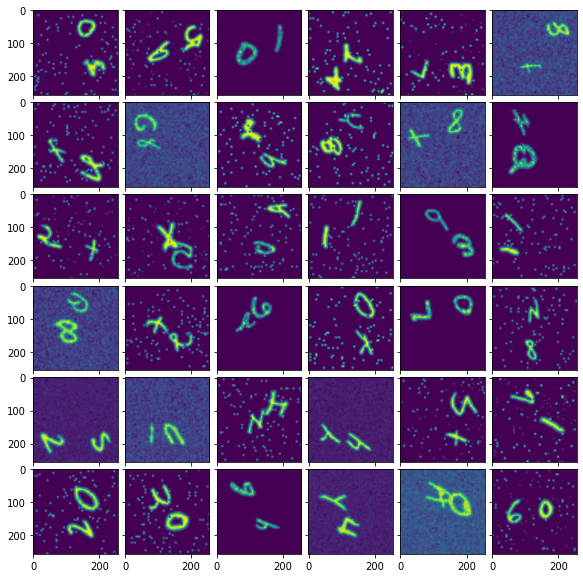

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig2 = plt.figure(figsize=(10., 10.))
grid2 = ImageGrid(fig2, 111, 
                 nrows_ncols=(6, 6), 
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid2, i_un):
    ax.imshow(im)

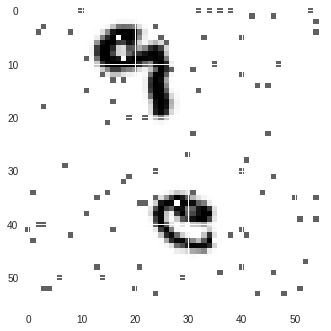

[[9 'e']]


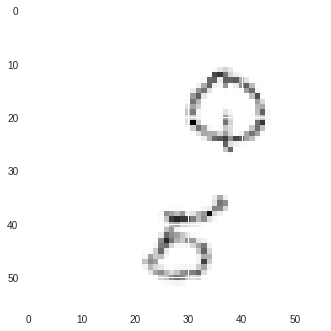

[[5 'q']]


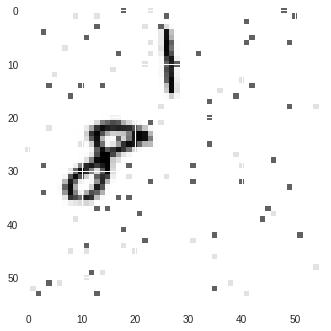

[[8 'i']]


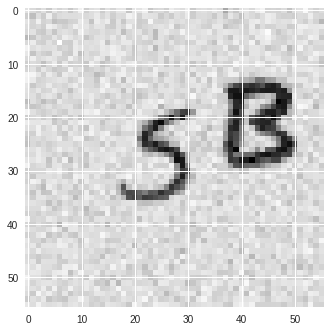

[[5 'b']]


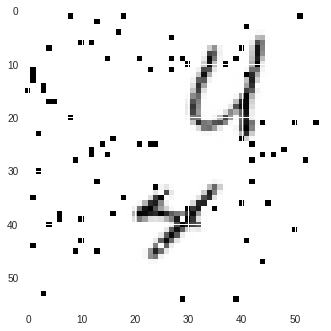

[[4 'u']]


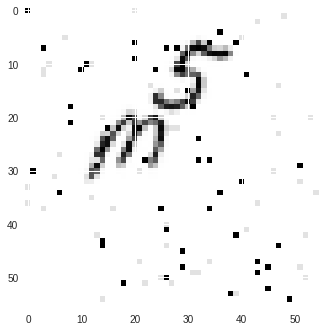

[[5 'm']]


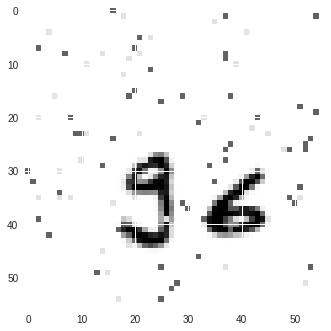

[[6 'g']]


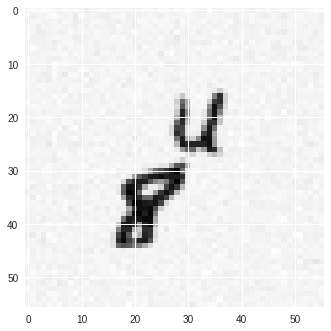

[[8 'u']]


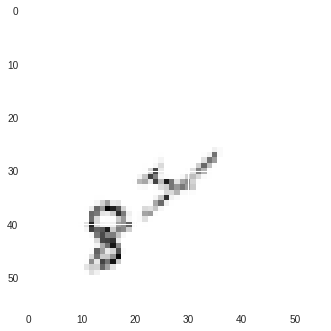

[[4 'q']]


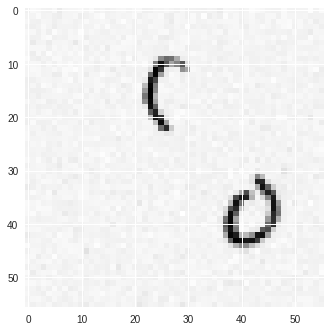

[[0 'c']]


In [ ]:
for i in range(0,10):
  plt.imshow(images_l[i], interpolation='nearest')
  plt.show()
  print(ohe.inverse_transform([labels[i]]))

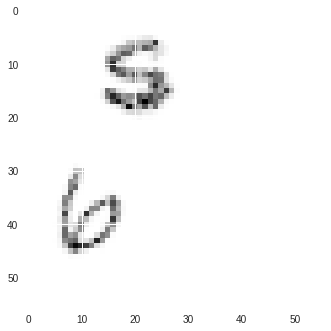

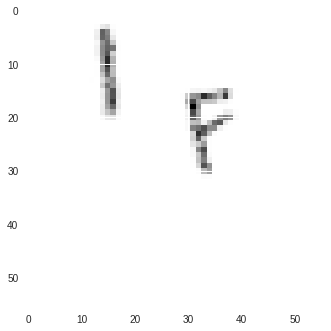

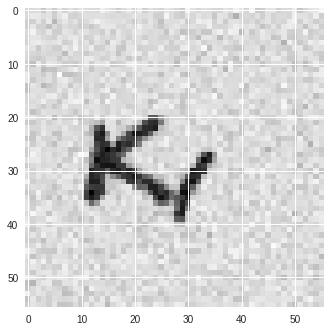

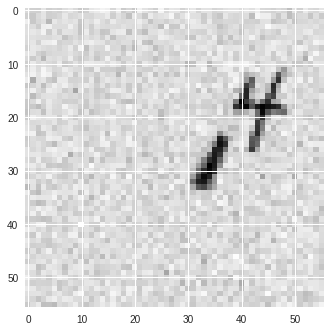

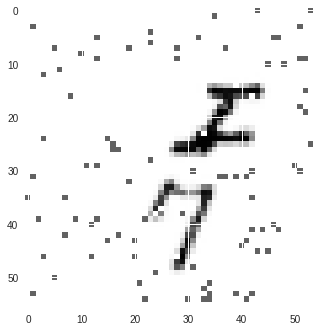

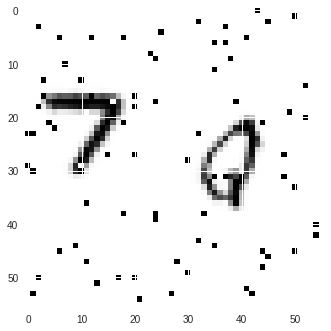

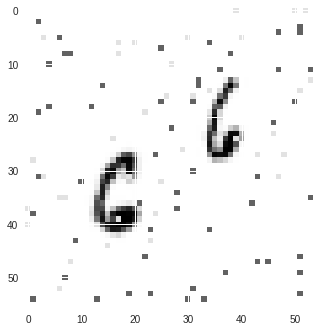

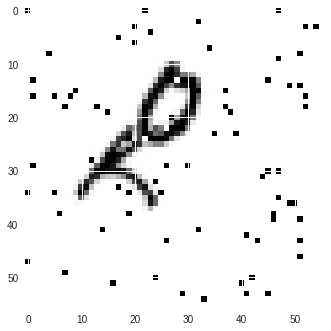

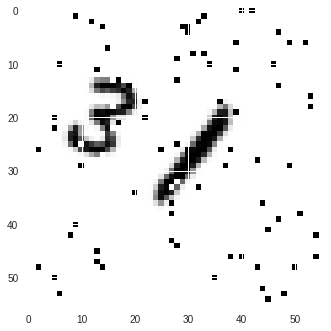

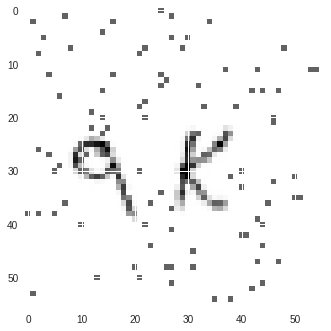

In [ ]:
for i in range(0,10):
  plt.imshow(images_ul[i], interpolation='nearest')
  plt.show()

## Dataloader

### Dataset classes

Dataset classes must be defined in order to make use of torch's dataloader, which manages batch dispatching.

Dataset classes included below are for labeled and unlabeled data, including a transform which will be used in producing pseudo-labeles for the unlabeled data. It is important that the pseudo-label transforms don't confuse the semantics of the image; for example, a transform which rotates by 180 degrees would turn a '4' into an 'h', thereby confusing the semantics of the image. Thus, we select angles of rotation: -45, 0, 45; in other words, the auxilary task will be recognizing the slant of symbols which were initially upright.

In [ ]:
class LabeledDataset(Dataset):
    def __init__(self,
                 labels: np.ndarray,
                 images: np.ndarray,
                 transform: Optional[transforms.Compose] = None):
        self.images = np.asarray(images).reshape(-1, 56, 56).astype('float32')
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        img = self.images[idx]
        if self.transform is not None:
            img = self.transform(img)
            
        img.unsqueeze(0)
        img = img.repeat(3,1,1)
        
        dict_data = {
            'img': img,
            'label': {
                'num': self.labels[idx][0],
                'char': self.labels[idx][1] } }
        
        return dict_data

In [ ]:
# sesemi_transform_categories = ('0', '35', '-35', 'hflip')
sesemi_transform_categories =  ('0', '90', '180', '270', 'hflip', 'vflip')

class SesemiTransform:

    classes = sesemi_transform_categories

    def __call__(self, x):
        tf_type = random.randint(0, len(self.classes) - 1)
        if tf_type == 0:
            x = x
        elif tf_type == 1:
            x = transforms.functional.rotate(x, 90)
        elif tf_type == 2:
            x = transforms.functional.rotate(x, 180)
        elif tf_type == 3:
            x = transforms.functional.rotate(x, 270)
        elif tf_type == 4:
            x = transforms.functional.hflip(x)
        elif tf_type == 5:
            x = transforms.functional.rotate(x, 180)
            x = transforms.functional.hflip(x)
        return x, tf_type
        
class UnlabeledDataset(Dataset):
    def __init__(self,
                 images: np.ndarray,
                 transform: Optional[transforms.Compose] = None):
        self.images = np.asarray(images).reshape(-1, 56, 56).astype('float32')
        self.transform = transform
        self.sesemi_transform = SesemiTransform()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        img = self.images[idx]
        if self.transform is not None:
            img = self.transform(img)
        
        img, label = self.sesemi_transform(img)

        img.unsqueeze(0)
        img = img.repeat(3,1,1)
        dict_data = {
            'img': img,
            'label': label}

        return dict_data

In [ ]:
class TestDataset(Dataset):
    def __init__(self,
                 images: np.ndarray,
                 transform: Optional[transforms.Compose] = None):
        self.images = np.asarray(images).reshape(-1, 56, 56).astype('float32')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        img = self.images[idx]
        if self.transform is not None:
            img = self.transform(img)

        img.unsqueeze(0)
        img = img.repeat(3,1,1)
        dict_data = {
            'img': img}

        return dict_data

### Transforms

A basic set of transformations is applied to all images, in order to conform it to the out-of-the-box architecture of MobileNetV2; the single channel of greyscale colour is tripled in order to emulate rgb, and the image is stretched to the minimum size of 256 pixels.

Additionally, in order to stretch our existing labeled data, a 'shake' can be applied to it to produce more similar, labeled data. These shakes include angled rotations of up to 10 degrees either direction (which additionally cause some noising in the image due to misalignment of pixels from the low-resolution), and horizontal and vertical translations in either direction of up to 3%. These transformations were selected as they most preserved the quality of the images in the style of the rest of the data; the numbers were oriented basically upright, and were not cropped out of the frame.

Although such a transformation can help make our model more robust, it is still possible to overfit on this augmented data, as ultimately it is not very distinct from the original labeled data (in order to be certain we preserve its semantic qualities); the relative positions of the symbols, for example, are still similar to those in the original data. Overfitting can cause associations with not only the semantic values which are represented in the image, but additionally with the relative positions of the symbols.

In [ ]:
basic_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5),(0.5)),
                                      transforms.ConvertImageDtype(torch.float32)])

In [ ]:
shake_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(256),
                                      transforms.ToTensor(),
                                      transforms.RandomAffine(degrees=10,
                                                              translate=(0.03, 0.03),
                                                              shear=None),
                                      transforms.Normalize((0.5),(0.5)),
                                      transforms.ConvertImageDtype(torch.float32)])

### Dataloader instantiations

DataLoader is used for batch management. We went for a batch size of 4, respectably small enough to give some protection against overfitting by stearing towards 'flat' optima; respectably large enough to converge at a reasonable rate.

In [ ]:
data = LabeledDataset(labels = decoded_labels,
                      images = images_l,
                      transform = basic_transform)

training_basic_data, validation_data = \
    torch.utils.data.random_split(data,
                                  [25000,5000],
                                  generator=torch.Generator().manual_seed(1))

augmented_data = LabeledDataset(labels = decoded_labels,
                                images = images_l,
                                transform = shake_transform)

training_augmented_data, validation_augmented_data = \
    torch.utils.data.random_split(data,
                                  [25000,5000],
                                  generator=torch.Generator().manual_seed(1))

relabeled_data = UnlabeledDataset(images = images_l,
                                  transform = basic_transform)

unlabeled_data = UnlabeledDataset(images = images_ul,
                                  transform = basic_transform)

test_data = TestDataset(images = images_test,
                        transform = basic_transform)

In [ ]:
full_dataloader = DataLoader(data,
                             batch_size = 4,
                             shuffle=True)

full_augmented_dataloader = DataLoader(augmented_data,
                                       batch_size = 4,
                                       shuffle=True)

train_basic_dataloader = DataLoader(training_basic_data,
                                    batch_size = 4,
                                    shuffle=True)

train_augmented_dataloader = DataLoader(training_augmented_data,
                                        batch_size = 4,
                                        shuffle=True)

valid_dataloader = DataLoader(validation_data,
                              batch_size = 4,
                              shuffle=True)

valid_augmented_dataloader = DataLoader(validation_augmented_data,
                                        batch_size = 4,
                                        shuffle=True)

relabeled_dataloader = DataLoader(relabeled_data,
                                  batch_size = 4,
                                  shuffle=True)

unlabeled_dataloader = DataLoader(unlabeled_data,
                                  batch_size = 4,
                                  shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size = 1,
                             shuffle=False)

### Sample batch outputs

In [ ]:
# Sample batch outputs of dataloaders

# functions to show an image
def imshow(img):
    img = img*0.5 + 0.5     # unnormalize
    npimg = np.transpose(img.numpy(),(1,2,0))
    npimg = npimg[:,:,0]
    plt.imshow(npimg)
    plt.show()

def sample_batch_output(dataloader, labelled="True"):
    bs = dataloader.batch_size
    d = iter(dataloader).next()
    if labelled:
        images, labels = d['img'], d['label']
        # show images
        imshow(torchvision.utils.make_grid(images))
        # print labels
        print(' '.join('%5s' % [num_categories[labels['num'][j]], char_categories[labels['char'][j]]] for j in range(bs)))
    else:
        images= d['img']
        # show images
        imshow(torchvision.utils.make_grid(images))

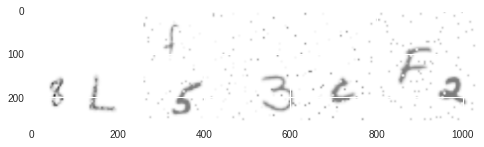

[8, 'l'] [5, 'f'] [3, 'c'] [2, 'f']


In [ ]:
sample_batch_output(train_basic_dataloader)

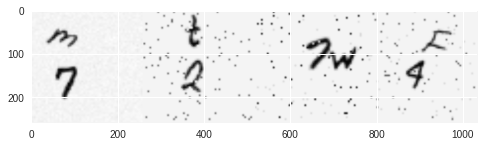

[7, 'm'] [2, 't'] [7, 'w'] [4, 'f']


In [ ]:
sample_batch_output(valid_dataloader)

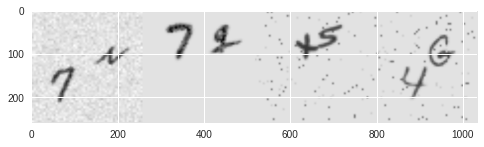

[7, 'n'] [7, 'g'] [5, 't'] [4, 'g']


In [ ]:
sample_batch_output(train_augmented_dataloader)

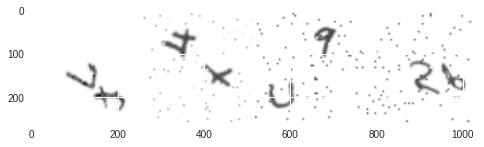

In [ ]:
sample_batch_output(unlabeled_dataloader, False)

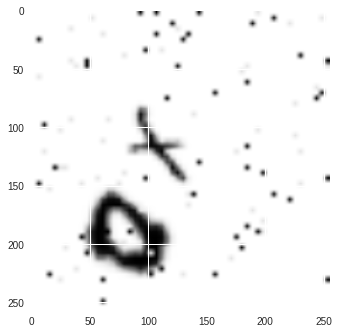

In [ ]:
#batch size=1
sample_batch_output(test_dataloader, False)

# Models

These models make multi-attribute predictions, one for the digit and one for the character represented in the image. For the backbone of the model, some ikea-like out-of-the-box architectures from torchvision is used, namely, MobileNetV2 and ResNet. For this, our images had to be adapted to fit, by enlarging them and trippling the single channel greyscale values to immitate three-channel rgb.

This model is also adapted to use pseudo-labeled data. Like the many heads of the Hydra, the body of the architecture splits into three heads: two for the digit and character attributes, and a third one for the pseudo-labels.

In [ ]:
# mobilenetv2 backbone, with multiple heads for multi-outputs and SESEMI training
class MultiOutputSesemiMobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = torchvision.models.mobilenet_v2(pretrained = False).features  # take the model without classifier
        last_channel = torchvision.models.mobilenet_v2(pretrained = False).last_channel # size of the layer before the classifier

        # reduce <width> and <height> to 1 dimension
        # for input into classifiers
        self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        # create separate classifiers for our outputs
        # like the many heads of the Hydra
        self.sup_num = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel,
                      out_features=len(num_categories))
        )
        self.sup_char = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel,
                      out_features=len(char_categories))
        )
        self.selfsup = \
            nn.Linear(in_features=last_channel,
                      out_features=len(sesemi_transform_categories))

    def forward(self, x: torch.Tensor, x_selfsup: Optional[torch.Tensor] = None):
        # supervised training
        # 1) mobilenet
        # 2) pool to reduce <width> and <height> to 1 dimension
        # 3) reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        # 4) some of the many heads of the Hydra: num and char
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        dict_data = {'num': self.sup_num(x),
                     'char': self.sup_char(x)}

        # self-supervised training
        # 1) mobilenet
        # 2) pool to reduce <width> and <height> to 1 dimension
        # 3) reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        # 4) the secretly-most-influential of the many heads of the Hydra: selfsup
        if x_selfsup is not None:
            x_selfsup = self.base_model(x_selfsup)
            x_selfsup = self.pool(x_selfsup)
            x_selfsup = torch.flatten(x_selfsup, start_dim=1)
            x_selfsup = self.selfsup(x_selfsup)
            return dict_data, x_selfsup
        else:
            return dict_data

In [ ]:
# ResNet backbone, with multiple heads for multi-outputs and SESEMI training
class MultiOutputSesemiResNet(nn.Module):
    def __init__(self):
        super().__init__()

        # ResNet backbone
        self.base_model = torchvision.models.resnet50(pretrained = False)
        # last_channel = torchvision.models.resnet50(pretrained = False).last_channel # size of the layer before the classifier
        last_channel = 256
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, last_channel)

        # create separate classifiers for our outputs
        # like the many heads of the Hydra
        self.sup_num_fc = \
            nn.Linear(in_features=last_channel,
                      out_features=len(num_categories))
        self.sup_char_fc = \
            nn.Linear(in_features=last_channel,
                      out_features=len(char_categories))
        self.selfsup_fc = \
            nn.Linear(in_features=last_channel,
                      out_features=len(sesemi_transform_categories))

    def forward(self, x: torch.Tensor, x_selfsup: Optional[torch.Tensor] = None):
        # supervised training
        # 1) resnet
        # 2) some of the many heads of the Hydra: num and char
        x = self.base_model(x)
        dict_data = {'num': self.sup_num_fc(x),
                     'char': self.sup_char_fc(x)}

        # self-supervised training
        # 1) resnet
        # 2) the secretly-most-influential of the many heads of the Hydra: selfsup
        if x_selfsup is not None:
            x_selfsup = self.base_model(x_selfsup)
            x_selfsup = self.selfsup_fc(x_selfsup)
            return dict_data, x_selfsup
        else:
            return dict_data

In [ ]:
# mobilenetv2 backbone, with multiple heads for multi-outputs
# completely equivalent to MultiOutputSesemiMobileNet but
# with variable names to match our Molly model
class MollyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = torchvision.models.mobilenet_v2(pretrained = False).features  # take the model without classifier
        last_channel = torchvision.models.mobilenet_v2(pretrained = False).last_channel # size of the layer before the classifier

        # reduce <width> and <height> to 1 dimension
        # for input into classifiers
        self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        # create separate classifiers for our outputs
        # like the many heads of the Hydra
        self.num = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel,
                      out_features=len(num_categories))
        )
        self.char = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel,
                      out_features=len(char_categories))
        )
        self.selfsup = nn.Linear(in_features=last_channel,
                                 out_features=len(sesemi_transform_categories))

    def forward(self, x: torch.Tensor, x_selfsup: Optional[torch.Tensor] = None):
        # supervised training
        # 1) mobilenet
        # 2) pool to reduce <width> and <height> to 1 dimension
        # 3) reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        # 4) some of the many heads of the Hydra: num and char
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        dict_data = {'num': self.num(x),
                     'char': self.char(x)}


        # self-supervised training
        # 1) mobilenet
        # 2) pool to reduce <width> and <height> to 1 dimension
        # 3) reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        # 4) the greatest of the many heads of the Hydra: selfsup
        if x_selfsup is not None:
            x_selfsup = self.base_model(x_selfsup)
            x_selfsup = self.pool(x_selfsup)
            x_selfsup = torch.flatten(x_selfsup, start_dim=1)
            x_selfsup = self.selfsup(x_selfsup)
            return dict_data, x_selfsup
        else:
            return dict_data

    # def get_loss(self, net_output, ground_truth):
    #     num_loss = F.cross_entropy(net_output['num'].to(device), ground_truth['num'].to(device))
    #     char_loss = F.cross_entropy(net_output['char'].to(device), ground_truth['char'].to(device))
    #     loss = num_loss + char_loss
    #     return loss, {'num': num_loss, 'char': char_loss}

# Train

## Access GPU

In [ ]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, the following should print a CUDA device
print(device)

cpu


## Training loop and predict function

We define our training loop and our prediction function (which is used both within and outside of the training loop).

In [ ]:
# Train the network function
# If validation data is included, training/validation accuracies will be evaluated
# Default value for val_dataloader is an empty DataLoader
# If unlabeled data is included, it will be used for semi-supervised learning
# Default value for unlabeled_trainloader is an empty DataLoader
def train(
    model: nn.Module,
    labeled_trainloader: DataLoader,
    unlabeled_trainloader: Optional[DataLoader] = None,
    val_dataloader: Optional[DataLoader] = None,
    PATH = None,
    epoch_num: int = 2,
    sup_num_wt: float = 1.0,
    sup_char_wt: float = 1.0,
    unsup_wt: float = 1.0
):

    # Access GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_num_acc = []
    val_num_acc = []
    train_char_acc = []
    val_char_acc = []

    best_accuracy = 0

    # Epoch processing
    for epoch in range(epoch_num):
        model.train()

        running_loss = 0.0
        train_loss_sum = 0.0
        running_loss_sup = 0.0
        running_loss_unsup = 0.0

        # Put the labeled and unlabeled data together,
        # if there is unlabeled data
        dataloaders = zip(labeled_trainloader, [None] * len(labeled_trainloader))\
            if unlabeled_trainloader is None\
            else zip(labeled_trainloader, unlabeled_trainloader)

        # Batch processing
        for i, (sup_data, unsup_data) in enumerate(dataloaders, start=0):

            # zero the parameter gradients
            optimizer.zero_grad()

            # get the supervised data; data dict of [inputs, labels]
            sup_inputs = sup_data['img']
            sup_labels = sup_data['label']
            
            # forward + backward + optimize
            if unsup_data is None:
                # forward pass with only labeled data
                sup_outputs = model(x=sup_inputs.to(device))

                # 'compute' individual losses
                loss_unsup = 0.0
            else:
                # Separate unlabeled data from it's pseudo-labels
                # data dict of [inputs, labels]
                unsup_inputs = unsup_data['img'].to(device)
                unsup_labels = unsup_data['label'].to(device)

                # forward pass through model with both data subsets
                sup_outputs, unsup_outputs = model(x=sup_inputs.to(device),
                                                   x_selfsup=unsup_inputs.to(device))

                # compute individual losses
                unsup_criterion = nn.CrossEntropyLoss()
                loss_unsup = unsup_criterion(unsup_outputs, unsup_labels)
                running_loss_unsup += loss_unsup.item()
            
            # more losses & backwards pass
            loss_sup_num = F.cross_entropy(sup_outputs['num'].to(device),
                                           sup_labels['num'].to(device))
            loss_sup_char = F.cross_entropy(sup_outputs['char'].to(device),
                                            sup_labels['char'].to(device))
            loss_sup = sup_num_wt * loss_sup_num + sup_char_wt * loss_sup_char
            loss = loss_sup + unsup_wt * loss_unsup
            loss.backward()

            # optimize
            optimizer.step()

            iter_loss = loss_sup.item()
            running_loss_sup += iter_loss
            train_loss_sum += iter_loss

            # print statistics
            if i % 2000 == 1999:
                if unsup_data is None:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss (sup): {running_loss_sup / 2000:.4f}')
                else:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss (sup): {running_loss_sup / 2000:.4f} '\
                        f'loss (unsup): {running_loss_unsup / 2000:.4f}')
                running_loss_sup = 0.0
                running_loss_unsup = 0.0

        # Training accuracy
        pred_num, gt_num, pred_char, gt_char = predict(model, labeled_trainloader)
        num_train_accuracy = accuracy_score(gt_num, pred_num)
        char_train_accuracy = accuracy_score(gt_char, pred_char)
        train_num_acc.append(num_train_accuracy)
        train_char_acc.append(char_train_accuracy)
        avg_train_accuracy = (num_train_accuracy + char_train_accuracy)/2
        print("Number training accuracy:", num_train_accuracy)
        print("Character training accuracy:", char_train_accuracy)
        print("Average training accuracy:", avg_train_accuracy)
        
        # saving the epoch information
        if PATH != None:
            rootPATH = PATH[:PATH.rindex('.')]
            # the model
            torch.save(model.state_dict(), rootPATH + '_epoch' + f'_{epoch+1}.pth')
        else:
            rootPATH = "model"
        # always save the uptodate lists of the accuracies
        with open(rootPATH + "_train_num.txt", 'w') as f:
            for s in train_num_acc:
                f.write(str(s) + '\n')
        with open(rootPATH + "_train_char.txt", 'w') as f:
            for s in train_char_acc:
                f.write(str(s) + '\n')

        # Validation accuracy, if we're doing that
        if val_dataloader is not None:

            val_pred_num, val_gt_num, val_pred_char, val_gt_char = predict(model, val_dataloader)
            num_val_accuracy = accuracy_score(val_gt_num, val_pred_num)
            char_val_accuracy = accuracy_score(val_gt_char, val_pred_char)
            val_num_acc.append(num_val_accuracy)
            val_char_acc.append(char_val_accuracy)
            avg_val_accuracy = (num_val_accuracy + char_val_accuracy)/2
            print("Number validation accuracy:", num_val_accuracy)
            print("Character validation accuracy:", char_val_accuracy)
            print("Average validation accuracy:", avg_val_accuracy)
            

            # saving the epoch information
            # always save the uptodate lists of the accuracies
            with open(rootPATH + "_val_num.txt", 'w') as f:
                for s in val_num_acc:
                    f.write(str(s) + '\n')
            with open(rootPATH + "_val_char.txt", 'w') as f:
                for s in val_char_acc:
                    f.write(str(s) + '\n')
            # Update the record of the best trained model, if we're saving it
            if PATH != None and avg_val_accuracy > best_accuracy:
                best_accuracy = avg_val_accuracy
                print("! new best !")  
                torch.save(model.state_dict(), PATH)


    print('Finished Training')

    if val_dataloader is not None:
        return train_num_acc, train_char_acc, val_num_acc, val_char_acc
    else:
        if PATH != None:
            # Save the last trained model
            torch.save(model.state_dict(), PATH)
        return train_num_acc, train_char_acc

In [ ]:
def predict(model, dataloader, islabeled = True):
  # put the model into evaluation mode
  model.eval()
 
  # initialize storage for ground truth and predicted labels
  predicted_num_all = []
  gt_num_all = []

  predicted_char_all = []
  gt_char_all = []
 
  # go over all the images
  for batch in dataloader:
      # load this batch of images
      images = batch["img"]

      # get the model predictions for the images
      output = model(images.to(device))
 
      # select the model's most confident prediction
      _, predicted_num = output["num"].cpu().max(1)
      _, predicted_char = output["char"].cpu().max(1)
 
      # Add predictions to list
      predicted_num_all.extend(
          prediction.item() for prediction in predicted_num)
      predicted_char_all.extend(
          prediction.item() for prediction in predicted_char)

      # to make sure labels (if they exist) are in the same order as predictions
      if islabeled:
          # load this batch of labels
          gt_num = batch["label"]["num"]
          gt_char = batch["label"]["char"]
          target_labels = {"num": gt_num.to(device), "char": gt_char.to(device)}
 
          # add labels to list
          gt_num_all.extend(
              gt_num.item() for gt_num in gt_num)
          gt_char_all.extend(
              gt_char.item() for gt_char in gt_char)

  if islabeled:
      return predicted_num_all, gt_num_all,le.inverse_transform(predicted_char_all), le.inverse_transform(gt_char_all)
  else:
      return predicted_num_all, le.inverse_transform(predicted_char_all)

In [ ]:
# In case runtime crashes, what data was gathered can be loaded in
with open("MobileNet_Sesemi_1a_train_num.txt", 'r') as f:
  train_num_acc_1a = f.readlines()
with open("MobileNet_Sesemi_1a_train_char.txt", 'r') as f:
  train_char_acc_1a = f.readlines()
with open("MobileNet_Sesemi_1a_val_num.txt", 'r') as f:
  val_num_acc_1a = f.readlines()
with open("MobileNet_Sesemi_1a_val_char.txt", 'r') as f:
  val_char_acc_1a = f.readlines()

## (1) Phase 1: no augmented data

### (a) Baseline: MobileNetV2, char loss wgt = 5, with auxiliary training

As a first pass, we train a new, randomly-initiated multi-output model. The training set was transformed to fit an acceptable form for input into the out-of-the-box network architecture MobileNetV2.

We use a validation set for 'early stopping' in order to not overfit the model; however, we do not terminate our training, but rather opt to simply save the model with the best validation accuracy. We continue to the end of our 50 epochs in order to produce a pretty plot of the training vs. validation accuracies.

In [ ]:
# Start a new MobileNet model from scratch
modelMobile = MultiOutputSesemiMobileNet().to(device)

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(modelMobile.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# train the network with validation evaluation for 50 epochs
train_num_acc_1a, train_char_acc_1a, val_num_acc_1a, val_char_acc_1a = \
  train(model = model,
        labeled_trainloader = train_basic_dataloader,
        unlabeled_trainloader = relabeled_dataloader,
        val_dataloader = valid_dataloader,
        PATH = './Phase_1a.pth',
        epoch_num = 50,
        sup_char_wt = 5)

[1,  2000] loss (sup): 15.1323 loss (unsup): 1.6580
[1,  4000] loss (sup): 12.4894 loss (unsup): 1.5883
[1,  6000] loss (sup): 10.1661 loss (unsup): 1.5357
Number training accuracy: 0.56788
Character training accuracy: 0.55056
Average training accuracy: 0.55922
Number validation accuracy: 0.5554
Character validation accuracy: 0.546
Average validation accuracy: 0.5507
[2,  2000] loss (sup): 8.5038 loss (unsup): 1.4958
[2,  4000] loss (sup): 7.5510 loss (unsup): 1.4672
[2,  6000] loss (sup): 6.7616 loss (unsup): 1.3966
Number training accuracy: 0.77088
Character training accuracy: 0.681
Average training accuracy: 0.72594
Number validation accuracy: 0.7726
Character validation accuracy: 0.6546
Average validation accuracy: 0.7136
[3,  2000] loss (sup): 5.8243 loss (unsup): 1.3458
[3,  4000] loss (sup): 5.5277 loss (unsup): 1.2971
[3,  6000] loss (sup): 5.0757 loss (unsup): 1.2527
Number training accuracy: 0.84768
Character training accuracy: 0.79044
Average training accuracy: 0.81906
Numbe

In [ ]:
fig = go.Figure(layout=go.Layout(title = "MobileNetV2 with auxiliary task, weighted<br>Phase 1 (non-augmented training data):<br> training and validation accuracy",
                                 xaxis_title = "epoch",
                                 yaxis_title = "accuracy",
                                 height=500, width=800) )

fig.add_scatter(y=train_num_acc_1a,
                name = "number accuracy on training data")
fig.add_scatter(y=val_num_acc_1a,
                name="number accuracy on validation data")
fig.add_scatter(y=train_char_acc_1a,
                name = "character accuracy on training data")
fig.add_scatter(y=val_char_acc_1a,
                name="character accuracy on validation data")

fig.show(renderer="colab")

### (b) Impact of relative weighted loss

We set a relative weight of 5 for the character training, as we know that this is the most difficult of all tasks; it has the greatest number of categories, as well as the most varying in representation, due in part to classes of characters being grouped together modulo their case. We therefore wish to give special attention to it. We witness here how the accuracy of character classification lagged behind, but was corrected for by giving the character loss a higher weight in its contribution to the total loss.

In [ ]:
# Start a new MobileNet model from scratch
modelMobile = MultiOutputSesemiMobileNet().to(device)

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(modelMobile.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# train the network with validation evaluation for 20 epochs
train_num_acc_1b, train_char_acc_1b, val_num_acc_1b, val_char_acc_1b = \
  train(model = modelMobile,
        labeled_trainloader = train_basic_dataloader,
        unlabeled_trainloader = relabeled_dataloader,
        val_dataloader = valid_dataloader,
        PATH = './Phase_1b.pth',
        epoch_num = 20,
        sup_char_wt = 1)

[1,  2000] loss (sup): 18.6264 loss (unsup): 1.7768
[1,  4000] loss (sup): 17.9494 loss (unsup): 1.7342
[1,  6000] loss (sup): 17.3298 loss (unsup): 1.7776
Number training accuracy: 0.14296
Character training accuracy: 0.1402
Average training accuracy: 0.14157999999999998
Number validation accuracy: 0.1408
Character validation accuracy: 0.1366
Average validation accuracy: 0.1387
! new best !
Finished Training


In [ ]:
fig = go.Figure(layout=go.Layout(title = "MobileNetV2 with auxiliary task, unweighted<br>Phase 1 (non-augmented training data):<br> training and validation accuracy",
                                 xaxis_title = "epoch",
                                 yaxis_title = "accuracy",
                                 height=500, width=800) )

fig.add_scatter(y=train_num_acc_1b,
                name = "number accuracy on training data")
fig.add_scatter(y=val_num_acc_1b,
                name="number accuracy on validation data")
fig.add_scatter(y=train_char_acc_1b,
                name = "character accuracy on training data")
fig.add_scatter(y=val_char_acc_1b,
                name="character accuracy on validation data")

fig.show(renderer="colab")

### (c) MolbileNetV2 vs. ResNet50

Comparison using ResNet50 as the backbone of the model, instead of MobileNetV2. Basically, even if ResNet50 produces more accurate results, it's just too slow to be practical.

In [ ]:
# Start a new MobileNet model from scratch
modelMobile = MultiOutputSesemiMobileNet().to(device)

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(modelMobile.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# train the network with validation evaluation for 50 epochs
train_num_acc_1c, train_char_acc_1c, val_num_acc_1c, val_char_acc_1c = \
  train(model = resnet_model,
        labeled_trainloader = train_basic_dataloader,
        unlabeled_trainloader = relabeled_dataloader,
        val_dataloader = valid_dataloader,
        PATH = './Phase_1c.pth',
        epoch_num = 50,
        sup_char_wt = 5)

[1,  2000] loss (sup): 18.8684 loss (unsup): 1.8009
[1,  4000] loss (sup): 18.0425 loss (unsup): 1.7746
[1,  6000] loss (sup): 17.1211 loss (unsup): 1.6610
Number training accuracy: 0.28228
Character training accuracy: 0.16744
Average training accuracy: 0.22486
Number validation accuracy: 0.2702
Character validation accuracy: 0.1682
Average validation accuracy: 0.2192
! new best !
[2,  2000] loss (sup): 15.6883 loss (unsup): 1.6197
[2,  4000] loss (sup): 13.9837 loss (unsup): 1.5749
[2,  6000] loss (sup): 11.3524 loss (unsup): 1.5458
Number training accuracy: 0.50448
Character training accuracy: 0.48632
Average training accuracy: 0.4954
Number validation accuracy: 0.5132
Character validation accuracy: 0.484
Average validation accuracy: 0.4986
! new best !
[3,  2000] loss (sup): 8.6740 loss (unsup): 1.4517
[3,  4000] loss (sup): 7.2600 loss (unsup): 1.3805
[3,  6000] loss (sup): 6.2987 loss (unsup): 1.2780
Number training accuracy: 0.76176
Character training accuracy: 0.72884
Average tr

In [ ]:
fig = go.Figure(layout=go.Layout(title = "ResNet50 with auxiliary task, weighted<br>Phase 1 (non-augmented training data):<br> training and validation accuracy",
                                 xaxis_title = "epoch",
                                 yaxis_title = "accuracy",
                                 height=500, width=800) )

fig.add_scatter(y=train_num_acc_1c,
                name = "number accuracy on training data")
fig.add_scatter(y=val_num_acc_1c,
                name="number accuracy on validation data")
fig.add_scatter(y=train_char_acc_1c,
                name = "character accuracy on training data")
fig.add_scatter(y=val_char_acc_1c,
                name="character accuracy on validation data")

fig.show(renderer="colab")

### (d) Impact of auxiliary training

In all our other models, we invented an auxiliary task for training on the labeled data, where we applied transformations to the labeled data, and then used the model to additionally predict the pseudo-labels - this is the same as the SESEMI technique, but applied to the already-labeled data rather than to a complete new, unlabeled dataset. Here, we compare the effect of not using this technique.

In [ ]:
# Start a new MobileNet model from scratch
modelMobile = MultiOutputSesemiMobileNet().to(device)

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(modelMobile.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# train the network with validation evaluation for 50 epochs
train_num_acc_1d, train_char_acc_1d, val_num_acc_1d, val_char_acc_1d = \
  train(model = model,
        labeled_trainloader = train_basic_dataloader,
        val_dataloader = valid_dataloader,
        PATH = './Phase_1d.pth',
        epoch_num = 50,
        sup_char_wt = 5)

[1,  2000] loss (sup): 15.3207
[1,  4000] loss (sup): 14.3591
[1,  6000] loss (sup): 12.7007
Number training accuracy: 0.31288
Character training accuracy: 0.3028
Average training accuracy: 0.30784
Number validation accuracy: 0.3124
Character validation accuracy: 0.3026
Average validation accuracy: 0.3075
! new best !
[2,  2000] loss (sup): 10.0967
[2,  4000] loss (sup): 8.2334
[2,  6000] loss (sup): 6.7427
Number training accuracy: 0.75832
Character training accuracy: 0.68416
Average training accuracy: 0.72124
Number validation accuracy: 0.754
Character validation accuracy: 0.669
Average validation accuracy: 0.7115
! new best !
[3,  2000] loss (sup): 5.6953
[3,  4000] loss (sup): 5.0571
[3,  6000] loss (sup): 4.5559
Number training accuracy: 0.86196
Character training accuracy: 0.77644
Average training accuracy: 0.8191999999999999
Number validation accuracy: 0.8542
Character validation accuracy: 0.7552
Average validation accuracy: 0.8047
! new best !
[4,  2000] loss (sup): 4.1906
[4, 

In [ ]:
fig = go.Figure(layout=go.Layout(title = "MobileNetV2 without auxiliary task, weighted<br>Phase 1 (non-augmented training data):<br> training and validation accuracy",
                                 xaxis_title = "epoch",
                                 yaxis_title = "accuracy",
                                 height=500, width=800) )

fig.add_scatter(y=train_num_acc_1d,
                name = "number accuracy on training data")
fig.add_scatter(y=val_num_acc_1d,
                name="number accuracy on validation data")
fig.add_scatter(y=train_char_acc_1d,
                name = "character accuracy on training data")
fig.add_scatter(y=val_char_acc_1d,
                name="character accuracy on validation data")

fig.show(renderer="colab")

### (e) SESEMI and other Pseudo-labeling strategies

Since we were given 30k unlabeled samples, we want to make the most of our dataprovided. We compare here the use of pseudo-labeled data produced by applying the SESEMI technique. This is a form of semi-supervised learning.

In [ ]:
# Start a new MobileNet model from scratch
modelMobile = MultiOutputSesemiMobileNet().to(device)

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(modelMobile.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# train the network with validation evaluation for 50 epochs
train_num_acc_1a, train_char_acc_1a, val_num_acc_1a, val_char_acc_1a = \
  train(model = modelMobile,
        labeled_trainloader = train_basic_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        val_dataloader = valid_dataloader,
        PATH = './MobileNet_Sesemi_1e.pth',
        epoch_num = 20,
        sup_char_wt = 5)

[1,  2000] loss (sup): 18.5606 loss (unsup): 1.7352
[1,  4000] loss (sup): 18.0674 loss (unsup): 1.7540
[1,  6000] loss (sup): 17.5937 loss (unsup): 1.7973
Number training accuracy: 0.1812
Character training accuracy: 0.10292
Average training accuracy: 0.14206
Number validation accuracy: 0.177
Character validation accuracy: 0.095
Average validation accuracy: 0.136
! new best !
[2,  2000] loss (sup): 16.8830 loss (unsup): 1.7842
[2,  4000] loss (sup): 15.3211 loss (unsup): 1.7020
[2,  6000] loss (sup): 13.4280 loss (unsup): 1.6240
Number training accuracy: 0.40672
Character training accuracy: 0.4244
Average training accuracy: 0.41556000000000004
Number validation accuracy: 0.4114
Character validation accuracy: 0.421
Average validation accuracy: 0.4162
! new best !
[3,  2000] loss (sup): 10.9437 loss (unsup): 1.5702
[3,  4000] loss (sup): 9.2470 loss (unsup): 1.5424
[3,  6000] loss (sup): 7.9755 loss (unsup): 1.5060
Number training accuracy: 0.6698
Character training accuracy: 0.6912
Ave

In [ ]:
fig = go.Figure(layout=go.Layout(title = "MobileNetV2 with true SESEMI auxiliary task, weighted<br>Phase 1 (non-augmented training data):<br> training and validation accuracy",
                                 xaxis_title = "epoch",
                                 yaxis_title = "accuracy",
                                 height=500, width=800) )

fig.add_scatter(y=train_num_acc_1e,
                name = "number accuracy on training data")
fig.add_scatter(y=val_num_acc_1e,
                name="number accuracy on validation data")
fig.add_scatter(y=train_char_acc_1e,
                name = "character accuracy on training data")
fig.add_scatter(y=val_char_acc_1e,
                name="character accuracy on validation data")

fig.show(renderer="colab")

## (2) Phase 2: using augmented labeled data

Secondly, we further train the models using the labeled training data that has been transformed with a small 'shake': it is rotated to a maximum of 10 degrees left or right, and translated vertically or horizontally either direction up to a maximum of 3% the size of the image.

Again, we use the validation set to estimate early stopping (by saving the model with the best validation accuracy, but continuing onwards in order to make our pretty plots of the training vs. validation accuracies).

And again, we use the pseudo-labeled data.

In [ ]:
# Load the best previously trained model from 'basic' training
model = MultiOutputSesemiMobileNet().to(device)
model.load_state_dict(torch.load('./MobileNet_Sesemi_1.pth',
                                 map_location=torch.device(device)))

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# train the network with validation evaluation for 50 epochs
train_num_acc_2, train_char_acc_2, val_num_acc_2, val_char_acc_2 = \
  train(model = model,
        labeled_trainloader = train_augmented_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        val_dataloader = valid_dataloader,
        PATH = './MobileNet_Sesemi_2.pth',
        epoch_num = 50,
        sup_char_wt = 5)

[1,  2000] loss (sup): 0.3713 loss (unsup): 0.4335
[1,  4000] loss (sup): 0.4646 loss (unsup): 0.4235
[1,  6000] loss (sup): 0.3858 loss (unsup): 0.4219
Number training accuracy: 0.98468
Character training accuracy: 0.99072
Average training accuracy: 0.9877
Number validation accuracy: 0.956
Character validation accuracy: 0.9084
Average validation accuracy: 0.9321999999999999
[2,  2000] loss (sup): 0.2875 loss (unsup): 0.4160
[2,  4000] loss (sup): 0.4527 loss (unsup): 0.4024
[2,  6000] loss (sup): 0.3971 loss (unsup): 0.4117
Number training accuracy: 0.98544
Character training accuracy: 0.99128
Average training accuracy: 0.98836
Number validation accuracy: 0.9522
Character validation accuracy: 0.911
Average validation accuracy: 0.9316
[3,  2000] loss (sup): 0.3112 loss (unsup): 0.4082
[3,  4000] loss (sup): 0.4607 loss (unsup): 0.4239
[3,  6000] loss (sup): 0.3842 loss (unsup): 0.4200
Number training accuracy: 0.98448
Character training accuracy: 0.9806
Average training accuracy: 0.982

In [ ]:
fig = go.Figure(layout=go.Layout(title = "MobileNetV2 with auxiliary task, weighted<br>Phase 2 (non-augmented training data):<br> training and validation accuracy",
                                 xaxis_title = "epoch",
                                 yaxis_title = "accuracy",
                                 height=500, width=800) )

fig.add_scatter(y=train_num_acc_2,
                name = "number accuracy on training data")
fig.add_scatter(y=val_num_acc_2,
                name="number accuracy on validation data")
fig.add_scatter(y=train_char_acc_2,
                name = "character accuracy on training data")
fig.add_scatter(y=val_char_acc_2,
                name="character accuracy on validation data")

fig.show(renderer="colab")

## (3) Putting it all together: a complete run without validation

In order to make the most of our labeled data, we additionally use the labeled data which we had previously set aside exclusively for validation. For this part of the training, we have no way to check for overfitting; however, our models do not seem to show signs of overfitting based on test results from kaggle.


### SESEMI

This model is trained in several phases:


1. 20 epochs with the unaugmented training set, lr = 0.001, character weight = 5.
2. 14 epochs with the augmented training set, lr = 0.0001, character weight = 2.
3. 5 epochs with the unaugmented training set, lr = 0.00001 (default), character weight = 1.
4. 67 epochs same as previous but with augmented training set.
5. 12 epochs same as previous but with SESEMI unlabeled dataset training.
6. 2 epochs same as above but with lr = 0.000001.
7. 4 epochs same as above but with lr = 0.0000001.

In [ ]:
# Start a new model from scratch
model = MultiOutputSesemiMobileNet().to(device)

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# train the network with validation evaluation for 20 epochs
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        PATH = './Sesemi_5.pth',
        epoch_num = 20,
        sup_char_wt = 5)

[1,  2000] loss (sup): 11.9027 loss (unsup): 1.6389
[1,  4000] loss (sup): 9.5597 loss (unsup): 1.5587
[1,  6000] loss (sup): 8.0475 loss (unsup): 1.4838
Number training accuracy: 0.7689333333333334
Character training accuracy: 0.7218
Average training accuracy: 0.7453666666666667
[2,  2000] loss (sup): 6.0126 loss (unsup): 1.4076
[2,  4000] loss (sup): 5.6282 loss (unsup): 1.3629
[2,  6000] loss (sup): 5.1516 loss (unsup): 1.3348
Number training accuracy: 0.8465333333333334
Character training accuracy: 0.7972333333333333
Average training accuracy: 0.8218833333333333
[3,  2000] loss (sup): 4.3472 loss (unsup): 1.2580
[3,  4000] loss (sup): 4.1022 loss (unsup): 1.2499
[3,  6000] loss (sup): 3.8691 loss (unsup): 1.2197
Number training accuracy: 0.8828666666666667
Character training accuracy: 0.8334333333333334
Average training accuracy: 0.85815
[4,  2000] loss (sup): 3.4042 loss (unsup): 1.1530
[4,  4000] loss (sup): 3.3091 loss (unsup): 1.1118
[4,  6000] loss (sup): 3.1428 loss (unsup): 

In [ ]:
# In case runtime crashes, what data was gathered can be found here
with open("Mobile_Sesemi_phase_3_train_num.txt", 'rb') as f:
  m_train_num_acc_1a = f.read().splitlines()
with open("Mobile_Sesemi_phase_3_train_char.txt", 'rb') as f:
  m_train_char_acc_1a = f.read().splitlines()

In [ ]:
fig = go.Figure(layout=go.Layout(title = "SESEMI with augmented training data:<br> training and validation accuracy",
                                 xaxis_title = "epoch",
                                 yaxis_title = "accuracy",
                                 height=500, width=800) )

fig.add_scatter(y=train_num_acc_3,
                name = "number accuracy on training data")
fig.add_scatter(y=train_char_acc_3,
                name = "character accuracy on training data")

fig.show(renderer="colab")

In [ ]:
model.load_state_dict(torch.load('./Sesemi_5_epoch_9.pth'))

In [ ]:
# slower learning rate for later phases of epochs
# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# train the network with validation evaluation for 20 epochs (cut short at 7)
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_augmented_dataloader,
        unlabeled_trainloader = relabeled_dataloader,
        PATH = './Sesemi_6.pth',
        epoch_num = 20,
        sup_char_wt = 2)

[1,  2000] loss (sup): 0.5786 loss (unsup): 0.4728
[1,  4000] loss (sup): 0.4993 loss (unsup): 0.4467
[1,  6000] loss (sup): 0.4825 loss (unsup): 0.4478
Number training accuracy: 0.9689
Character training accuracy: 0.9629
Average training accuracy: 0.9659
[2,  2000] loss (sup): 0.4137 loss (unsup): 0.4219
[2,  4000] loss (sup): 0.4069 loss (unsup): 0.4133
[2,  6000] loss (sup): 0.3888 loss (unsup): 0.4095
Number training accuracy: 0.9694333333333334
Character training accuracy: 0.9656333333333333
Average training accuracy: 0.9675333333333334
[3,  2000] loss (sup): 0.3803 loss (unsup): 0.3986
[3,  4000] loss (sup): 0.3437 loss (unsup): 0.4167
[3,  6000] loss (sup): 0.4024 loss (unsup): 0.4038
Number training accuracy: 0.9716
Character training accuracy: 0.9685666666666667
Average training accuracy: 0.9700833333333334
[4,  2000] loss (sup): 0.3540 loss (unsup): 0.3921
[4,  4000] loss (sup): 0.3444 loss (unsup): 0.3886
[4,  6000] loss (sup): 0.3605 loss (unsup): 0.3999
Number training acc

KeyboardInterrupt: ignored

In [ ]:
# slower learning rate for later phases of epochs
# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# train the network with validation evaluation for 20 (cut short at 7)
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_augmented_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        PATH = './Sesemi_7.pth',
        epoch_num = 20,
        sup_char_wt = 2)

[1,  2000] loss (sup): 0.2765 loss (unsup): 0.3518
[1,  4000] loss (sup): 0.3001 loss (unsup): 0.3694
[1,  6000] loss (sup): 0.2731 loss (unsup): 0.3576
Number training accuracy: 0.9757333333333333
Character training accuracy: 0.9755333333333334
Average training accuracy: 0.9756333333333334
[2,  2000] loss (sup): 0.3081 loss (unsup): 0.3505
[2,  4000] loss (sup): 0.2773 loss (unsup): 0.3473
[2,  6000] loss (sup): 0.2830 loss (unsup): 0.3549
Number training accuracy: 0.9766666666666667
Character training accuracy: 0.975
Average training accuracy: 0.9758333333333333
[3,  2000] loss (sup): 0.2888 loss (unsup): 0.3564
[3,  4000] loss (sup): 0.2716 loss (unsup): 0.3410
[3,  6000] loss (sup): 0.2861 loss (unsup): 0.3390
Number training accuracy: 0.9777
Character training accuracy: 0.9761
Average training accuracy: 0.9769
[4,  2000] loss (sup): 0.2768 loss (unsup): 0.3452
[4,  4000] loss (sup): 0.2666 loss (unsup): 0.3569
[4,  6000] loss (sup): 0.2933 loss (unsup): 0.3501
Number training accu

KeyboardInterrupt: ignored

In [ ]:
# Start a new model from scratch
model = MultiOutputSesemiNet().to(device)

model.load_state_dict(torch.load('./Sesemi_7_epoch_7.pth'))

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# train the network with validation evaluation for 5
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        PATH = './Sesemi_8.pth',
        epoch_num = 5,
        sup_char_wt = 1)

[1,  2000] loss (sup): 0.1652 loss (unsup): 0.4735
[1,  4000] loss (sup): 0.1858 loss (unsup): 0.4757
[1,  6000] loss (sup): 0.2086 loss (unsup): 0.4744
Number training accuracy: 0.9767666666666667
Character training accuracy: 0.9844666666666667
Average training accuracy: 0.9806166666666667
[2,  2000] loss (sup): 0.1804 loss (unsup): 0.4282
[2,  4000] loss (sup): 0.1904 loss (unsup): 0.4235
[2,  6000] loss (sup): 0.2094 loss (unsup): 0.4481
Number training accuracy: 0.9777
Character training accuracy: 0.9829333333333333
Average training accuracy: 0.9803166666666667
[3,  2000] loss (sup): 0.1714 loss (unsup): 0.4292
[3,  4000] loss (sup): 0.1741 loss (unsup): 0.4184
[3,  6000] loss (sup): 0.2135 loss (unsup): 0.4163
Number training accuracy: 0.9868333333333333
Character training accuracy: 0.9849666666666667
Average training accuracy: 0.9859
[4,  2000] loss (sup): 0.1630 loss (unsup): 0.4118
[4,  4000] loss (sup): 0.1750 loss (unsup): 0.4058
[4,  6000] loss (sup): 0.1793 loss (unsup): 0.

In [ ]:
# train the network with validation evaluation for 2
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_augmented_dataloader,
        unlabeled_trainloader = relabeled_dataloader,
        PATH = './Sesemi_9.pth',
        epoch_num = 2,
        sup_char_wt = 1)

[1,  2000] loss (sup): 0.3683 loss (unsup): 0.3893
[1,  4000] loss (sup): 0.3465 loss (unsup): 0.3829
[1,  6000] loss (sup): 0.3384 loss (unsup): 0.3753
Number training accuracy: 0.9702
Character training accuracy: 0.9516333333333333
Average training accuracy: 0.9609166666666666
[2,  2000] loss (sup): 0.3125 loss (unsup): 0.3677
[2,  4000] loss (sup): 0.3279 loss (unsup): 0.3693
[2,  6000] loss (sup): 0.3145 loss (unsup): 0.3969
Number training accuracy: 0.9712666666666666
Character training accuracy: 0.9507666666666666
Average training accuracy: 0.9610166666666666
Finished Training


In [ ]:
model = MultiOutputSesemiNet().to(device)
model.load_state_dict(torch.load('./Sesemi_9_epoch_2.pth'))

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# train the network with validation evaluation for 20 epochs
# (try again for another 20 after that)
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_augmented_dataloader,
        unlabeled_trainloader = relabeled_dataloader,
        PATH = './Sesemi_10.pth',
        epoch_num = 50,
        sup_char_wt = 1)

[1,  2000] loss (sup): 0.2965 loss (unsup): 0.3595
[1,  4000] loss (sup): 0.3201 loss (unsup): 0.3724
[1,  6000] loss (sup): 0.2899 loss (unsup): 0.3733
Number training accuracy: 0.9692
Character training accuracy: 0.9549333333333333
Average training accuracy: 0.9620666666666666
[2,  2000] loss (sup): 0.2805 loss (unsup): 0.3630
[2,  4000] loss (sup): 0.2920 loss (unsup): 0.3770
[2,  6000] loss (sup): 0.2985 loss (unsup): 0.3541
Number training accuracy: 0.974
Character training accuracy: 0.9571
Average training accuracy: 0.9655499999999999
[3,  2000] loss (sup): 0.2847 loss (unsup): 0.3635
[3,  4000] loss (sup): 0.2780 loss (unsup): 0.3591
[3,  6000] loss (sup): 0.2848 loss (unsup): 0.3461
Number training accuracy: 0.9766333333333334
Character training accuracy: 0.9628666666666666
Average training accuracy: 0.96975
[4,  2000] loss (sup): 0.2667 loss (unsup): 0.3723
[4,  4000] loss (sup): 0.2708 loss (unsup): 0.3607
[4,  6000] loss (sup): 0.3053 loss (unsup): 0.3510
Number training acc

In [ ]:
# Start a new model from scratch
model = MultiOutputSesemiNet().to(device)

model.load_state_dict(torch.load('./Sesemi_10_epoch_50.pth'))

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# train the network with validation evaluation for 20 epochs (cut short at 15)
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_augmented_dataloader,
        unlabeled_trainloader = relabeled_dataloader,
        PATH = './Sesemi_11.pth',
        epoch_num = 20,
        sup_char_wt = 1)

[1,  2000] loss (sup): 0.0903 loss (unsup): 0.1842
[1,  4000] loss (sup): 0.0883 loss (unsup): 0.1840
[1,  6000] loss (sup): 0.0945 loss (unsup): 0.1953
Number training accuracy: 0.9904333333333334
Character training accuracy: 0.9882666666666666
Average training accuracy: 0.98935
[2,  2000] loss (sup): 0.0924 loss (unsup): 0.1852
[2,  4000] loss (sup): 0.0965 loss (unsup): 0.1988
[2,  6000] loss (sup): 0.0927 loss (unsup): 0.1768
Number training accuracy: 0.9935
Character training accuracy: 0.9898333333333333
Average training accuracy: 0.9916666666666667
[3,  2000] loss (sup): 0.0939 loss (unsup): 0.1783
[3,  4000] loss (sup): 0.0766 loss (unsup): 0.1902
[3,  6000] loss (sup): 0.1026 loss (unsup): 0.1936
Number training accuracy: 0.9921333333333333
Character training accuracy: 0.9903333333333333
Average training accuracy: 0.9912333333333333
[4,  2000] loss (sup): 0.0777 loss (unsup): 0.1917
[4,  4000] loss (sup): 0.0877 loss (unsup): 0.1875
[4,  6000] loss (sup): 0.0953 loss (unsup): 0

KeyboardInterrupt: ignored

In [ ]:
# train the network with validation evaluation for 50 epochs (cut short at 12)
# this is where real SESEMI starts
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_augmented_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        PATH = './Sesemi_12.pth',
        epoch_num = 50,
        sup_char_wt = 1)

[1,  2000] loss (sup): 0.0765 loss (unsup): 0.2787
[1,  4000] loss (sup): 0.0777 loss (unsup): 0.2448
[1,  6000] loss (sup): 0.0809 loss (unsup): 0.2415
Number training accuracy: 0.9946333333333334
Character training accuracy: 0.9925
Average training accuracy: 0.9935666666666667
[2,  2000] loss (sup): 0.0660 loss (unsup): 0.2427
[2,  4000] loss (sup): 0.0876 loss (unsup): 0.2370
[2,  6000] loss (sup): 0.0797 loss (unsup): 0.2413
Number training accuracy: 0.9924
Character training accuracy: 0.9887333333333334
Average training accuracy: 0.9905666666666666
[3,  2000] loss (sup): 0.0657 loss (unsup): 0.2338
[3,  4000] loss (sup): 0.0754 loss (unsup): 0.2231
[3,  6000] loss (sup): 0.0809 loss (unsup): 0.2226
Number training accuracy: 0.9930666666666667
Character training accuracy: 0.9890666666666666
Average training accuracy: 0.9910666666666667
[4,  2000] loss (sup): 0.0655 loss (unsup): 0.2181
[4,  4000] loss (sup): 0.0714 loss (unsup): 0.2254
[4,  6000] loss (sup): 0.0732 loss (unsup): 0.

KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('./Sesemi_12_epoch_12.pth'))

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# train the network with validation evaluation for 20 epochs (cut short at 7)
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_augmented_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        PATH = './Sesemi_13.pth',
        epoch_num = 50,
        sup_char_wt = 1)

[1,  2000] loss (sup): 0.0574 loss (unsup): 0.1898
[1,  4000] loss (sup): 0.0707 loss (unsup): 0.1916
[1,  6000] loss (sup): 0.0606 loss (unsup): 0.1934
Number training accuracy: 0.9949666666666667
Character training accuracy: 0.9909666666666667
Average training accuracy: 0.9929666666666667
[2,  2000] loss (sup): 0.0621 loss (unsup): 0.1919
[2,  4000] loss (sup): 0.0691 loss (unsup): 0.1777
[2,  6000] loss (sup): 0.0734 loss (unsup): 0.1960
Number training accuracy: 0.9920333333333333
Character training accuracy: 0.9905
Average training accuracy: 0.9912666666666667
[3,  2000] loss (sup): 0.0677 loss (unsup): 0.1807
[3,  4000] loss (sup): 0.0758 loss (unsup): 0.1823
[3,  6000] loss (sup): 0.0598 loss (unsup): 0.1930
Number training accuracy: 0.9946666666666667
Character training accuracy: 0.9903
Average training accuracy: 0.9924833333333334
[4,  2000] loss (sup): 0.0656 loss (unsup): 0.1896
[4,  4000] loss (sup): 0.0629 loss (unsup): 0.1737
[4,  6000] loss (sup): 0.0649 loss (unsup): 0.

KeyboardInterrupt: ignored

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

# train the network with validation evaluation for 20 epochs (cut short at 2)
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = full_augmented_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        PATH = './Sesemi_14.pth',
        epoch_num = 50,
        sup_char_wt = 1)

[1,  2000] loss (sup): 0.0488 loss (unsup): 0.1675
[1,  4000] loss (sup): 0.0491 loss (unsup): 0.1651
[1,  6000] loss (sup): 0.0484 loss (unsup): 0.1600
Number training accuracy: 0.9961666666666666
Character training accuracy: 0.9926
Average training accuracy: 0.9943833333333334
[2,  2000] loss (sup): 0.0437 loss (unsup): 0.1571
[2,  4000] loss (sup): 0.0502 loss (unsup): 0.1583
[2,  6000] loss (sup): 0.0515 loss (unsup): 0.1616
Number training accuracy: 0.9967666666666667
Character training accuracy: 0.9929666666666667
Average training accuracy: 0.9948666666666667


KeyboardInterrupt: ignored

### *More* Pseudo-labels?!?

As another form of semi-supervised learning, we use our highly-trained model to make predictions on the unlabeled data; these predictions are then used as another form of pseudo-labels. In practice, the results from this were worse according to kaggle feedback. A better implementation would have taken multiple models and selected only the labels upon which they agree.

In [ ]:
realunlabel_data = TestDataset(images = images_ul,
                        transform = basic_transform)

realunlabel_dataloader = DataLoader(realunlabel_data,
                             batch_size = 1,
                             shuffle=False)

In [ ]:
# Make predictions on test set with best model
pred_num, pred_char = predict(model, realunlabel_dataloader, islabeled = False)

In [ ]:
predictions_unencoded = list(zip(pred_num, pred_char))
predictions_ohe = enc.transform(predictions_unencoded).toarray().astype(int)
newlabels = enc.inverse_transform(predictions_ohe)
newlabels[:,1] = le.transform(newlabels[:,1])

all_labels = np.concatenate((newlabels,decoded_labels))
all_images = np.concatenate((images_ul,images_l))

pseudodata = LabeledDataset(labels = all_labels,
                            images = all_images,
                            transform = basic_transform)
pseudo_dataloader = DataLoader(pseudodata,
                             batch_size = 4,
                             shuffle=True)

In [ ]:
# use the default learning rate now that starting with new data
optimizer = torch.optim.Adam(model.parameters())
# train the network with validation evaluation for 50 epochs (stopped at 3 to test)
train_num_acc_3, train_char_acc_3 = \
  train(model = model,
        labeled_trainloader = pseudo_dataloader,
        unlabeled_trainloader = unlabeled_dataloader,
        PATH = './Sesemi_19.pth',
        epoch_num = 50,
        sup_char_wt = 1)

[1,  2000] loss (sup): 0.0926 loss (unsup): 0.1564
[1,  4000] loss (sup): 0.1016 loss (unsup): 0.1826
[1,  6000] loss (sup): 0.1047 loss (unsup): 0.1838
Number training accuracy: 0.9927333333333334
Character training accuracy: 0.98335
Average training accuracy: 0.9880416666666667
[2,  2000] loss (sup): 0.0875 loss (unsup): 0.1674
[2,  4000] loss (sup): 0.0894 loss (unsup): 0.1755
[2,  6000] loss (sup): 0.0944 loss (unsup): 0.1723
Number training accuracy: 0.9940666666666667
Character training accuracy: 0.9911
Average training accuracy: 0.9925833333333334
[3,  2000] loss (sup): 0.0711 loss (unsup): 0.1737
[3,  4000] loss (sup): 0.0941 loss (unsup): 0.1624
[3,  6000] loss (sup): 0.0898 loss (unsup): 0.1669
Number training accuracy: 0.9948833333333333
Character training accuracy: 0.9904833333333334
Average training accuracy: 0.9926833333333334


KeyboardInterrupt: ignored

# Prediction and evaluation

In [ ]:
# Load the best previously trained model from training
model = MultiOutputSesemiMobileNet().to(device)
model.load_state_dict(torch.load('./Sesemi_3.pth',
                                 map_location=torch.device(device)))

# declare optimizer, default lr = 0.00001
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

<All keys matched successfully>

## Confusion matrices

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Make predictions with best model for complete dataset
pred_num, gt_num, pred_char, gt_char = \
  predict(model, full_dataloader)

<AxesSubplot:title={'center':'Numbers'}, xlabel='Predicted label', ylabel='True label'>

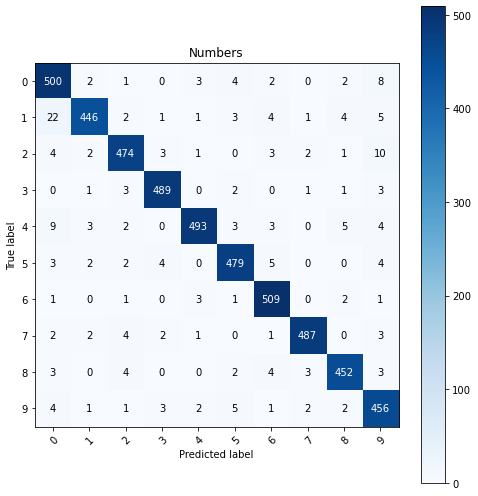

In [ ]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true = gt_num,
                      y_pred = pred_num,
                      classes = num_categories,
                      title = "Numbers")

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Characters'}, xlabel='Predicted label', ylabel='True label'>

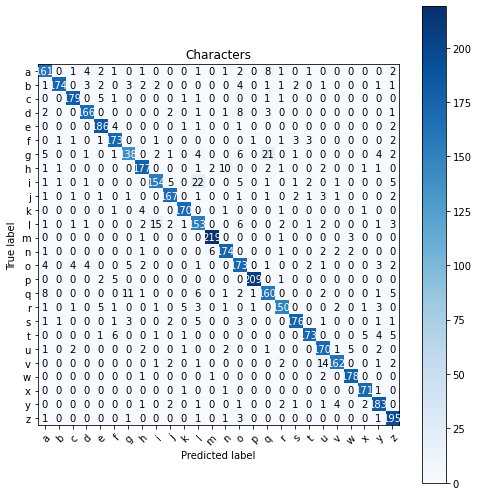

In [ ]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true = gt_char,
                      y_pred = pred_char,
                      classes = char_categories,
                      title="Characters")

## Predictions on test data

In [ ]:
predicted_char_all_decoded = le.inverse_transform(predicted_char_all)
predictions_unencoded = list(zip(predicted_num_all, predicted_char_all_decoded))
predictions_enc = ohe.transform(predictions_unencoded).toarray().astype(int)

In [ ]:
header = ["# Id", "Category"]

with open("submission.csv", "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(header)
    for i, prediction in enumerate(predictions_enc):
        prediction_as_str = "".join([str(int) for int in prediction])
        writer.writerow([i,prediction_as_str])